In [13]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from importlib import reload

import poppy_roman_cgi_phasec as cgi
from poppy_roman_cgi_phasec import hlc
import misc
reload(hlc)

cgi_dir = Path('C:/Users/Kian/Documents/data-files/roman-cgi-phasec-data')
# cgi_dir = Path('/Users/kianmilani/Documents/roman-cgi-phasec-data')

import logging, sys
_log = logging.getLogger('poppy')
_log.setLevel("DEBUG")
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

import poppy
import poppy.accel_math as am
print(am._USE_NUMEXPR)
print(am._USE_FFTW)
print(am._USE_MKL)
print(am._USE_OPENCL)
print(am._USE_CUDA)
poppy.conf.use_numexpr = True
poppy.conf.use_fftw = True
poppy.conf.use_mkl = True
poppy.conf.use_opencl = True
poppy.conf.use_cuda = False

True
True
True
True
False


INFO:poppy:Loaded influence function from proper_inf_func.fits for DM1
INFO:poppy:Loaded influence function from proper_inf_func.fits for DM2
INFO:poppy:Computing opd for DM1 sampled onto 512 pixel grid with pixelscale 0.09286875 mm / pix
DEBUG:poppy:Display pixel scale = 0.09286875 mm / pix 


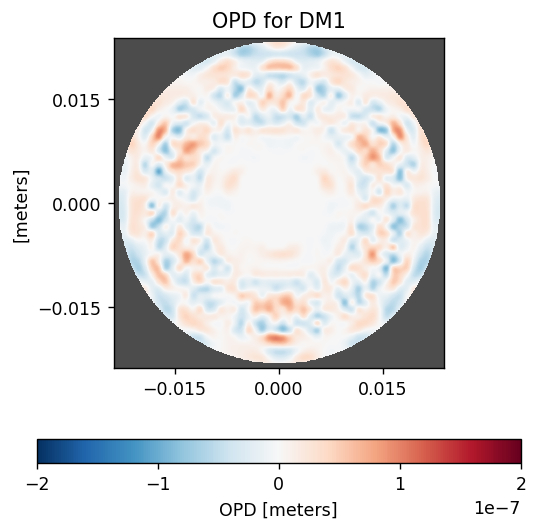

INFO:poppy:Computing opd for DM2 sampled onto 512 pixel grid with pixelscale 0.09286875 mm / pix
DEBUG:poppy:Display pixel scale = 0.09286875 mm / pix 


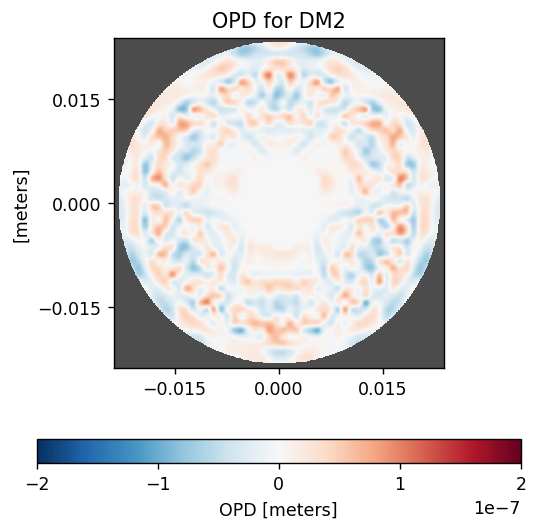

In [9]:
influence_func = fits.getdata('influence_dm5v2.fits')
wavelength_c = 575e-9*u.m
Nacts = 48
dm_diam = 46.3*u.mm
act_spacing = 0.9906*u.mm

dmdir = Path('C:/Users/Kian/Documents/data-files/dm-maps')
dm1_piston_fname = str(dmdir/'hlc_dm1_piston.fits')
dm2_piston_fname = str(dmdir/'hlc_dm2_piston.fits')

dm1 = poppy.ContinuousDeformableMirror(dm_shape=(Nacts,Nacts), name='DM1', actuator_spacing=act_spacing, radius=dm_diam/2,
                                       influence_func='proper_inf_func.fits')
dm1_piston_map = fits.getdata(dm1_piston_fname)
dm1.set_surface(dm1_piston_map)

dm2 = poppy.ContinuousDeformableMirror(dm_shape=(Nacts,Nacts), name='DM2', actuator_spacing=act_spacing, radius=dm_diam/2,
                                       influence_func='proper_inf_func.fits')
dm2_piston_map = fits.getdata(dm2_piston_fname)
dm2.set_surface(dm2_piston_map)

misc.display_dm(dm1)
misc.display_dm(dm2)

In [41]:
reload(hlc)

pxscl = 13e-6*u.m/u.pixel

pxscl_lamD_ref = 1/2
lambda_ref = 0.5*u.micron
D = 2.36*u.m
as_per_lamD = (lambda_ref/D * u.radian).to(u.arcsec)
pxscl_as_ref = as_per_lamD * pxscl_lamD_ref
print(pxscl_lamD_ref, pxscl_as_ref)

pxscl_lamD = pxscl_lamD_ref*1/(575/500)
pxscl_as = pxscl_as_ref*1/(575/500)
print(pxscl_lamD, pxscl_as)

wavelengths = np.linspace(575e-9 - 575e-9*.10/2, 575e-9 + 575e-9*.10/2, 7)*u.m
dm1s = ['hlc_dm1.fits', dm1]
dm2s = ['hlc_dm2.fits', dm2]

psfs, wfs = hlc.run_multi(mode='HLC575',
                          wavelength=wavelengths,
#                           dm1 = 'hlc_dm1.fits', dm2='hlc_dm2.fits',
#                           dm1=dm1s, dm2=dm2s,
                          npsf=64, psf_pixelscale=pxscl,
                          cgi_dir=cgi_dir,
#                           use_fieldstop=False,
#                           return_intermediates=True,
                         )

0.5 0.021850085407531392 arcsec
0.4347826086956522 0.019000074267418603 arcsec


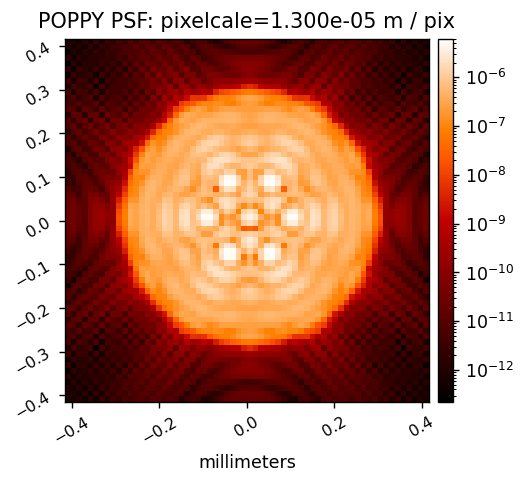

In [42]:
psf_multi = 0
for psf in psfs: psf_multi += psf.data
psf_multi /= len(psfs)

misc.myimshow(psf_multi, 'POPPY PSF: pixelcale={:.3e}'.format(wfs[0][-1].pixelscale),
              pxscl=wfs[0][-1].pixelscale.to(u.mm/u.pix),
              lognorm=True, cmap='gist_heat')

In [43]:
import proper
import roman_phasec_proper

lam_array = np.array([0.575])
lam_array = np.linspace(0.575 - 0.575*.10/2, 0.575 + 0.575*.10/2,7)
# lam_array = np.array([0.59895832])

n = 64                 # output image dimension (must be power of 2)
final_sampling = 0.1    # output sampling in lam0/D
final_sampling = 13e-6  # output sampling in meters

xoffset = 0
use_fpm = 1

use_hlc_dm_patterns = 0
use_errors = 0
use_dm1 = 0
use_dm2 = 0
if use_dm1==0: dm1 = 0
else: dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '\\examples\\hlc_best_contrast_dm1.fits' )
if use_dm2==0: dm2 = 0
else: dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '\\examples\\hlc_best_contrast_dm2.fits' )
polaxis = 0
use_fieldstop = 1
use_pupil_defocus = 0

(proper_wfs, proper_samplings_m) = proper.prop_run_multi('roman_phasec', lam_array, n, QUIET=False, 
                                                PASSVALUE={'cor_type':'hlc',
                                                           'final_sampling_m':final_sampling, 
                                                           'source_x_offset':xoffset,
                                                           'use_fpm':use_fpm,
                                                           'use_hlc_dm_patterns':use_hlc_dm_patterns,
                                                           'use_errors': use_errors,
                                                           'use_pupil_defocus':use_pupil_defocus,
                                                           'use_dm1':use_dm1, 'dm1_m':dm1, 
                                                           'use_dm2':use_dm2, 'dm2_m':dm2,
                                                           'use_field_stop':use_fieldstop,
                                                           'polaxis':polaxis,
                                                          })

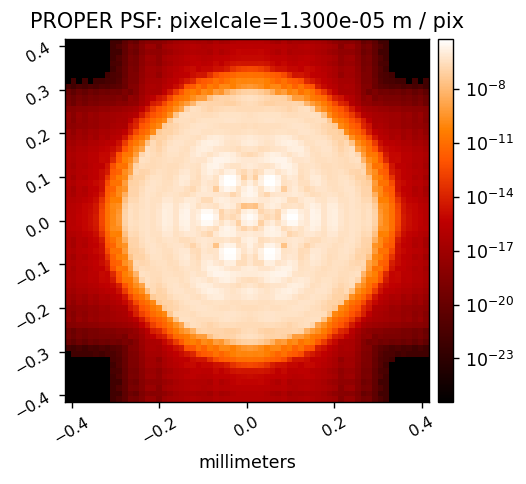

In [44]:
proper_psfs = np.abs(proper_wfs)**2

proper_psf = np.sum( proper_psfs, 0 ) / len(lam_array)
proper_sampling_m = proper_samplings_m[0]*u.m/u.pix

misc.myimshow(proper_psf, 'PROPER PSF: pixelcale={:.3e}'.format(proper_sampling_m),
              pxscl=proper_sampling_m.to(u.mm/u.pix), lognorm=True, cmap='gist_heat')

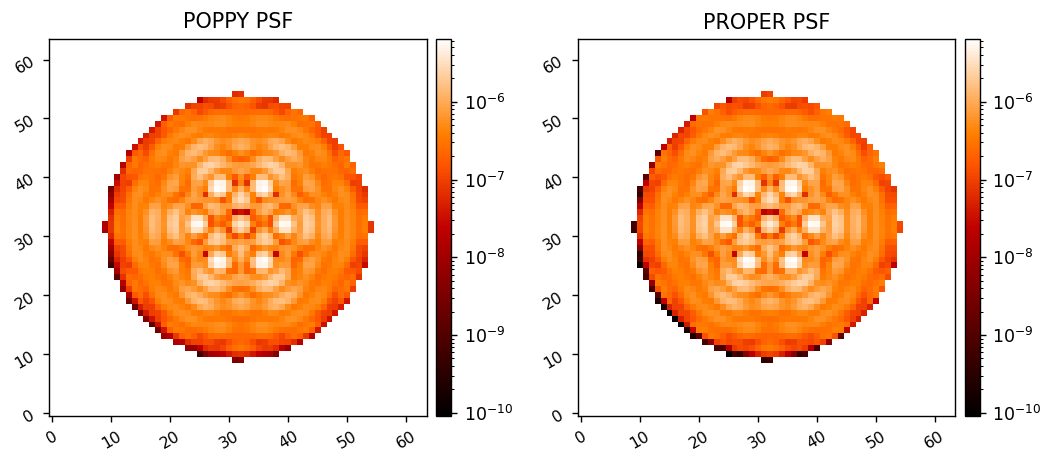

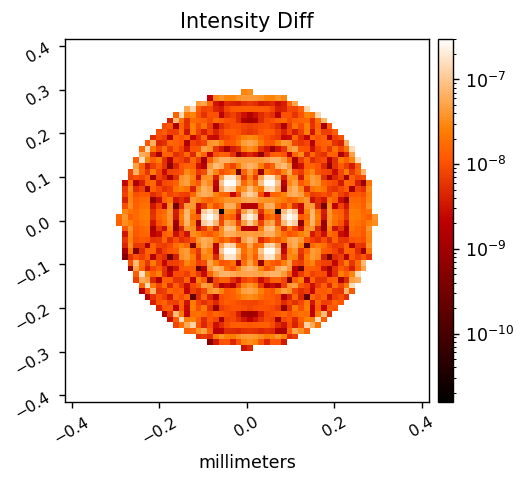

2.4228399603933994e-08 3.6300148520054256e-08
0.0009819984251641042
0.001013106984408986


In [53]:
from scipy.ndimage import rotate
from matplotlib.patches import Circle

pop_int = rotate(psf_multi,180)
pop_int = np.roll(np.roll(pop_int, 1, axis=0), 1, axis=1)
prop_int = proper_psf

iwa=2.7
owa=9.8
# np.roll(np.roll(misc.pad_or_crop(proper_data, 64), -1, axis=0), -1, axis=1)
pop_int = misc.mask_psf(pop_int, pixelscale=pxscl.value, pixelscale_lamD=pxscl_lamD, iwa=None, owa=owa)
prop_int = misc.mask_psf(prop_int, pixelscale=pxscl.value, pixelscale_lamD=pxscl_lamD, iwa=None, owa=owa)

psfs = np.ma.concatenate([pop_int, prop_int])
vmin=np.ma.min(psfs)
vmax=np.ma.max(psfs)
# vmax = 1e-12
# vmin = 1e-18

innwa = iwa/final_sampling*proper_sampling_m.value * 1000 # inner and outer working angles in units of m
outwa = owa/final_sampling*proper_sampling_m.value * 1000
patches1 = [Circle((0,0),innwa,edgecolor='c', facecolor='none',lw=1),
            Circle((0,0),outwa,edgecolor='c', facecolor='none',lw=1)]
patches2 = [Circle((0,0),innwa,edgecolor='c', facecolor='none',lw=1),
            Circle((0,0),outwa,edgecolor='c', facecolor='none',lw=1)]
misc.myimshow2(pop_int, prop_int, 'POPPY PSF', 'PROPER PSF',
               cmap1='gist_heat', cmap2='gist_heat', 
               lognorm1=True, lognorm2=True, vmin1=vmin, vmax1=vmax, vmin2=vmin, vmax2=vmax,
               pxscl=proper_sampling_m.to(u.mm/u.pix),
               patches1=patches1, patches2=patches2)

# Difference
int_diff = np.abs(pop_int-prop_int)
patches = [Circle((0,0),innwa,edgecolor='c', facecolor='none',lw=1),
            Circle((0,0),outwa,edgecolor='c', facecolor='none',lw=1)]
misc.myimshow(int_diff, 'Intensity Diff',
               pxscl=proper_sampling_m.to(u.mm/u.pix),
               lognorm=True, cmap='gist_heat',  patches=patches,)
print(np.ma.mean(int_diff), np.ma.std(int_diff))
print(np.ma.sum(pop_int))
print(np.ma.sum(prop_int))